# Name: Mohamad Jawad ABOU ALEIWI

# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task.
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [32]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/TP3/rncp.csv"

with open(file_path, encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [35]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity:

In [36]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [37]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [46]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 9432


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [47]:
from sklearn.model_selection import train_test_split

texts_reduced, test_texts, y_train, y_test = train_test_split(texts_reduced, labels_reduced, test_size=0.2, random_state=42)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools.
<div class='alert alert-block alert-info'>
            Code:</div>

In [48]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

<div class='alert alert-block alert-info'>
            Code:</div>

In [49]:
def clean_and_tokenize(text):

    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [50]:
def count_words(texts, voc = None):
    texts_list = []
    if  voc == None:
        # we do not have the dictionary, so we create a new dictionary
        voc = []
        for text in texts:
            texts_list.append(clean_and_tokenize(text))
            for word in texts_list[-1]:
                voc.append(word)
        voc = np.unique(np.asarray(voc))

        counts = np.zeros((len(texts_list), len(voc)))
        for i, text in enumerate(texts_list):
            for word in text:
                counts[i, np.where(voc == word)] += 1

        vocabulary = dict(zip(voc, range(len(voc))))
    return vocabulary, counts, texts_list

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

In [52]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

vocabulary, train_bow1, X_train = count_words(texts_reduced)
_, _, X_test = count_words(test_texts)
print("The vocabulary size is: ", len(vocabulary))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The vocabulary size is:  3585


The obtained vocabulary size is 3585 which is accepted, the dataset is of large size, and we have considered 9432 documnets. Further pre-processing steps may include handling rare words, domain-specific terminology, and error correction to improve model performance.

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics```

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [53]:
# Define a function to plot confusion matrix with colors
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [54]:
# Convert the list of lists of words into a list of strings
X_train_str = [' '.join(words) for words in X_train]

# Initialize CountVectorizer with your own vocabulary
count_vectorizer = CountVectorizer()

# Fit the vectorizer on training data
X_train_count = count_vectorizer.fit_transform(X_train_str)

# Transform test data using the same vectorizer
X_test_str = [' '.join(words) for words in X_test]
X_test_count = count_vectorizer.transform(X_test_str)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


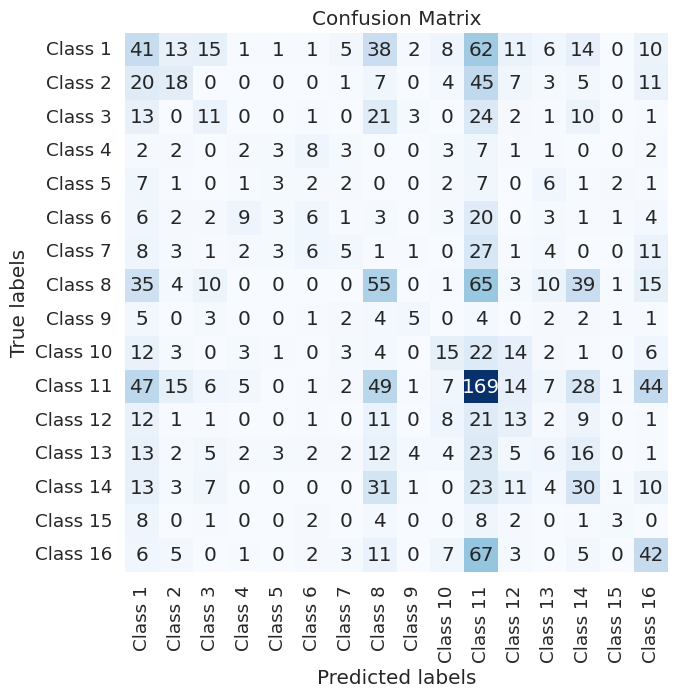

In [55]:
# Initialize LogisticRegression model
logistic_model_count = LogisticRegression()

# Train the model
logistic_model_count.fit(X_train_count, y_train)

# Predict on test data
y_pred_count = logistic_model_count.predict(X_test_count)

conf_matrix_count = confusion_matrix(y_test, y_pred_count)

# Modify labels to contain 16 classes
labels = ['Class {}'.format(i+1) for i in range(16)]

# Plot confusion matrix for CountVectorizer
plot_confusion_matrix(conf_matrix_count, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


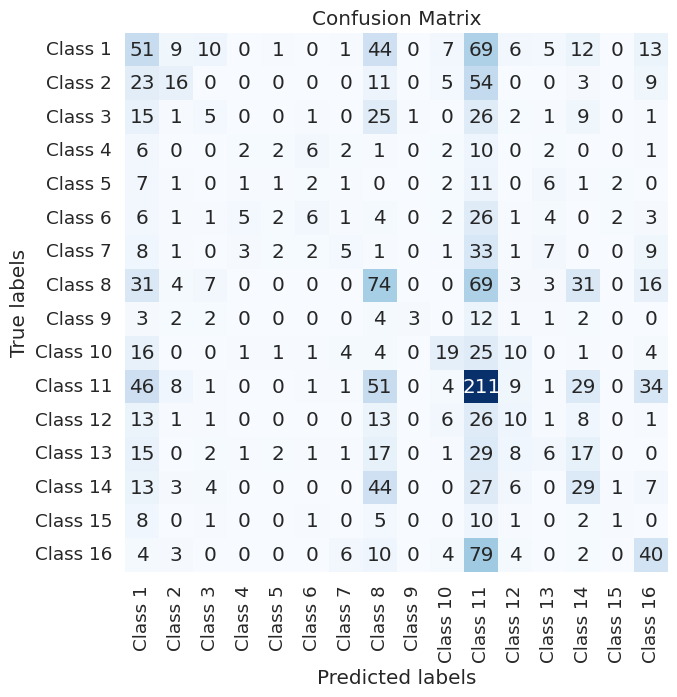

In [56]:
# Now repeat the same process with TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

logistic_model_tfidf = LogisticRegression()
logistic_model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = logistic_model_tfidf.predict(X_test_tfidf)

conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)

# Plot confusion matrix for CountVectorizer
plot_confusion_matrix(conf_matrix_tfidf, labels)

In [58]:
# Accuracy for CountVectorizer
accuracy_count = accuracy_score(y_test, y_pred_count)
print("Accuracy using CountVectorizer: ", accuracy_count)

# Accuracy for TfidfVectorizer
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print("Accuracy using TfidfVectorizer: ", accuracy_tfidf)

Accuracy using CountVectorizer:  0.22469528351881293
Accuracy using TfidfVectorizer:  0.2538420773714891


## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [59]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

# Define the number of topics
num_topics = 300

# Instantiate TruncatedSVD with desired number of topics
svd_model = TruncatedSVD(n_components=num_topics, random_state=42)

# Fit TruncatedSVD to the bag-of-words representations
X_train_svd = svd_model.fit_transform(train_bow1)

# Instantiate LatentDirichletAllocation with desired number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit LatentDirichletAllocation to the bag-of-words representations
X_train_lda = lda_model.fit_transform(train_bow1)


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ?

To choose the number of topics through data, conduct initial topic modeling with varying numbers of topics. Evaluate model performance using quantitative metrics like coherence scores and human evaluation. Select the number of topics that maximizes interpretability and coherence while considering domain relevance. Refine the model based on feedback and cross-validation.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

# Define the range of possible number of topics
param_grid = {'n_components': [50, 150, 500]}

# Instantiate LatentDirichletAllocation
lda_model = LatentDirichletAllocation()

# Perform GridSearchCV to find the best number of topics
grid_search = GridSearchCV(lda_model, param_grid, cv=5)
grid_search.fit(train_bow1)

# Get the best number of topics
best_num_topics = grid_search.best_params_['n_components']
print("Best number of topics:", best_num_topics)

Best number of topics: 50


50 topics emerged as the optimal choice, likely striking a balance between interpretability and coverage of themes. This number may have also ensured manageable computational complexity during training and inference. Ultimately, the model's performance, supported by evaluation metrics and downstream tasks, validated the effectiveness of the chosen number of topics.

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs.

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [60]:
def co_occurrence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-occurrence matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = [word.lower() for word in sent] # Lowercasing words
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary.get(word, len(vocabulary)-1) for word in sent] # Getting indexes or assigning to the unknown token
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
            sent_idx.append(len(vocabulary)-1) # This adds an Unknown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx_i in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = [sent_idx[max(0, i-window):i]] # Extracting left context within the window
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = [sent_idx[:i]] # Entire document is the context
            # Go through the list and update M[i,j] and M[j,i]:
            for j, idx_j in enumerate(l_ctx_idx):
                distance = abs(i - j) # Distance between the two words
                increment = 1 / (distance + 1) # Increment value based on distance
                M[idx_i, idx_j] += increment
                M[idx_j, idx_i] += increment
    return M

<div class='alert alert-block alert-info'>
            Code:</div>

In [61]:
from sklearn.decomposition import TruncatedSVD

def get_word_embeddings(co_occurrence_matrix, embedding_dim=300):
    svd = TruncatedSVD(n_components=embedding_dim, random_state=42)
    embeddings = svd.fit_transform(co_occurrence_matrix)
    return embeddings

In [62]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension

# the co-occurrence matrix
co_occ_matrix = co_occurrence_matrix(X_train, vocabulary, window=5)

# apply TruncatedSVD to reduce dimensionality
word_embeddings = get_word_embeddings(co_occ_matrix, embedding_dim=300)

<div class='alert alert-block alert-info'>
            Code:</div>

In [65]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    representations = []
    for text in texts:
        indexes = [vocabulary.get(word, len(vocabulary)-1) for word in text] # Indexes of words in the sentence obtained thanks to the vocabulary
        sent_embeddings = [embeddings[idx] for idx in indexes]
        sentrep = np_func(sent_embeddings, axis=0)
        representations.append(sentrep)
    representations = np.array(representations)
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# Obtain document representations for training data
train_representations = sentence_representations(X_train, vocabulary, word_embeddings)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(train_representations, y_train)

# Obtain document representations for testing data using the same word embeddings
test_representations = sentence_representations(X_test, vocabulary, word_embeddings)

# Evaluate the classifier
accuracy = classifier.score(test_representations, y_test)

print("Accuracy using TruncatedSVD without PPMI transformation: ", accuracy)

Accuracy using TruncatedSVD without PPMI transformation:  0.21038685744568097


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
def ppmi_matrix(co_occ_matrix):
    # Transform the co-occurrence matrix into the Positive Pointwise Mutual Information (PPMI) matrix.
    total_sum = np.sum(co_occ_matrix)
    row_sum = np.sum(co_occ_matrix, axis=1)
    col_sum = np.sum(co_occ_matrix, axis=0)
    ppmi = np.log(co_occ_matrix * total_sum / (np.outer(row_sum, col_sum)) + 1e-8)  # adding a small value to prevent log(0)
    ppmi[ppmi < 0] = 0  # Setting negative values to 0
    return ppmi

# Transform the co-occurrence matrix into the PPMI matrix
ppmi_matrix_train = ppmi_matrix(co_occ_matrix)

# TruncatedSVD to reduce dimensionality for training data
word_embeddings_train_ppmi = get_word_embeddings(ppmi_matrix_train, embedding_dim=300)


train_representations_ppmi = sentence_representations(X_train, vocabulary, word_embeddings_train_ppmi)
test_representations_ppmi = sentence_representations(X_test, vocabulary, word_embeddings_train_ppmi)

# Train a classifier on the PPMI-transformed representations
classifier_ppmi = LogisticRegression()
classifier_ppmi.fit(train_representations_ppmi, y_train)
accuracy_ppmi = classifier_ppmi.score(test_representations_ppmi, y_test)

print("Accuracy using TruncatedSVD with PPMI transformation:", accuracy_ppmi)

Accuracy using TruncatedSVD with PPMI transformation: 0.22628510863804982


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy using TruncatedSVD without PPMI transformation: 0.21038685744568097

Accuracy using TruncatedSVD with PPMI transformation: 0.22628510863804982

PPMI is a measure used to determine the association between two terms in a corpus. It measures how often two terms co-occur together compared to how often they would be expected to co-occur by chance.

The PPMI-based embeddings can enhance the model's accuracy, it improve performance by capturing more meaningful associations between words.


## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above.

In [71]:
from gensim.models import Word2Vec

In [84]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(vocabulary))

# Make a list of words
all_words = [word for sublist in X_train for word in sublist]

# Build vocabulary from the tokenized text data
model.build_vocab_from_freq({word: count for count, word in enumerate(all_words)})


<div class='alert alert-block alert-info'>
            Code:</div>

In [85]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = X_train

In [86]:
model.train(preprocessed_corpus, total_examples=len(preprocessed_corpus), epochs=30, report_delay=1)

(2343660, 2343660)

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification.
<div class='alert alert-block alert-info'>
            Code:</div>

In [87]:
document_representations = sentence_representations(texts_reduced, vocabulary, model.wv.vectors, np.mean)

In [88]:
X, X_val, y, y_val = train_test_split(document_representations, y_train, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X, y)

# Evaluate the model using accuracy
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy using Word2Vec:", accuracy)

Accuracy using Word2Vec: 0.19350563286944997


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ?
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ?

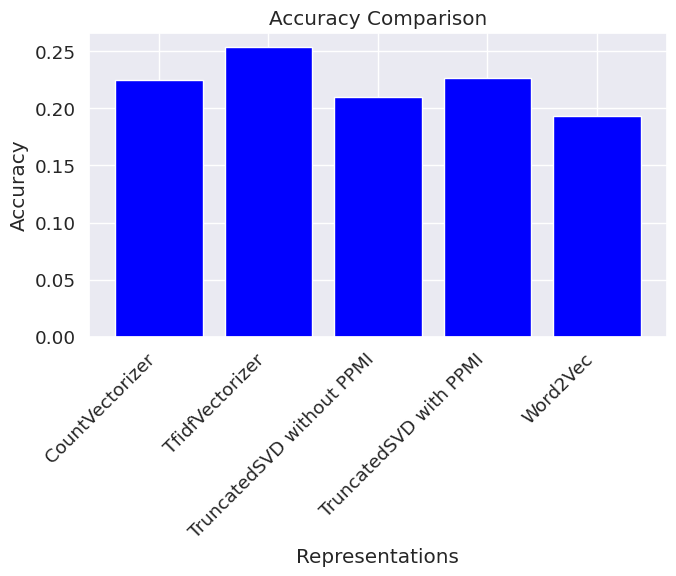

In [91]:
import matplotlib.pyplot as plt

rep = ['CountVectorizer', 'TfidfVectorizer', 'TruncatedSVD without PPMI', 'TruncatedSVD with PPMI', 'Word2Vec']
accuracies = [0.22469528351881293, 0.2538420773714891, 0.21038685744568097, 0.22628510863804982, 0.19350563286944997]

# Create the bar plot
plt.figure(figsize=(7, 6))
plt.bar(rep, accuracies, color='blue')
plt.title('Accuracy Comparison')
plt.xlabel('Representations')
plt.ylabel('Accuracy')
plt.grid('None')

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TfidfVectorizer's weighting mechanism, accounting for both term frequency and inverse document frequency, likely aids in capturing discriminative features. CountVectorizer's simplicity still proves effective, albeit slightly less so than TfidfVectorizer. The integration of PPMI transformation enhances TruncatedSVD's ability to preserve semantic information, resulting in a modest accuracy boost. However, Word2Vec's lower accuracy suggests that its embeddings may struggle to fully represent the task's semantic nuances or require additional tuning for optimal performance.

The dataset's challenge likely stems from its complexity, where embeddings alone couldn't capture nuanced semantic relationships. To improve performance, I'd suggest leveraging pre-trained embeddings like BERT or fine-tuning them on domain-specific data. Ensemble methods could combine predictions from diverse models, while domain-specific features and advanced preprocessing techniques could enhance the representation of textual information. Continuous model iteration based on error analysis and domain-specific considerations would be key in achieving robust performance in an industrial setting.